In [205]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    GridSearchCV
)
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    average_precision_score,
    roc_curve,
    roc_auc_score
)
from imblearn.over_sampling import SMOTE

### Import data

In [179]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
cervical_cancer_risk_factors = fetch_ucirepo(id=383) 
  
# data (as pandas dataframes) 
data = cervical_cancer_risk_factors.data.features 

### Assign columns for predictors and outcome

In [180]:
y = data[['Biopsy']]
X = data.iloc[:, 0:data.shape[1]-1]

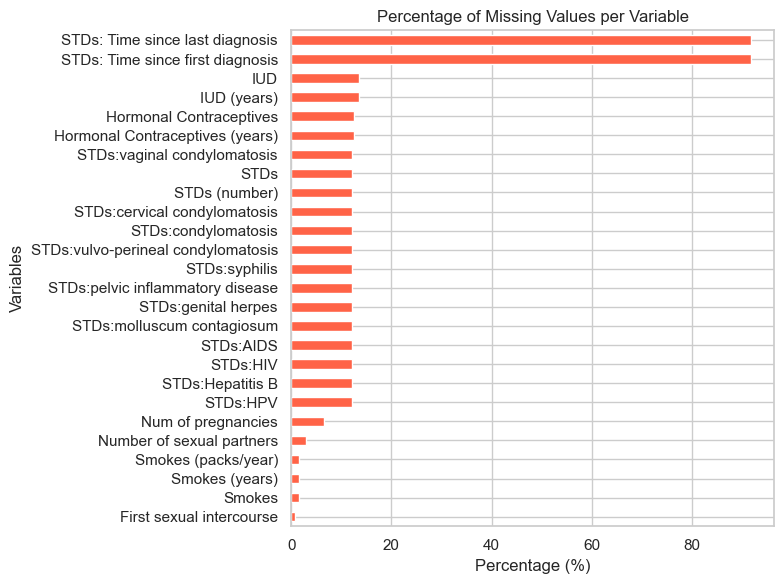

In [181]:
missing_percent = (X.isnull().sum() / len(X)) * 100
missing_percent = missing_percent[missing_percent > 0].sort_values(ascending=True)

# Check and plot
if not missing_percent.empty:
    plt.figure(figsize=(8, 6))
    missing_percent.plot(kind='barh', color='tomato')

    plt.title('Percentage of Missing Values per Variable')
    plt.xlabel('Percentage (%)')
    plt.ylabel('Variables')
    plt.tight_layout()
    plt.show()


In [182]:
vars_2_drop = [
    'STDs: Time since first diagnosis', 
    'STDs: Time since last diagnosis', 
    'STDs:cervical condylomatosis',
    'STDs:vaginal condylomatosis',
    'STDs:pelvic inflammatory disease',
    'STDs:genital herpes',
    'STDs:molluscum contagiosum',
    'STDs:AIDS',
    'STDs:Hepatitis B',
    'STDs:HPV',
    'Dx:CIN'
]
X.drop(columns=vars_2_drop, inplace=True)


In [183]:
imputed_mean = ['Number of sexual partners', 'First sexual intercourse', 'Num of pregnancies', 'Smokes (years)', 'Smokes (packs/year)', 'Hormonal Contraceptives (years)', 'IUD (years)', 'STDs (number)']
imputed_mode = ['Smokes', 'Hormonal Contraceptives', 'IUD', 'STDs', 'STDs:condylomatosis', 'STDs:vulvo-perineal condylomatosis', 'STDs:syphilis', 'STDs:HIV']
X.fillna(X[imputed_mean].mean(), inplace = True)
for col in imputed_mode:
  X.fillna({col: X[col].mode()[0]}, inplace=True)



In [184]:
continuous_X = [
    'Age',
    'Number of sexual partners',
    'First sexual intercourse',
    'Num of pregnancies',
    'Smokes (years)',
    'Smokes (packs/year)',
    'Hormonal Contraceptives (years)',
    'IUD (years)',
    'STDs (number)',
    'STDs: Number of diagnosis'
]
categorical_X = [
    'Smokes',
    'Hormonal Contraceptives',
    'IUD',
    'STDs',
    'STDs:condylomatosis',
    'STDs:vulvo-perineal condylomatosis',
    'STDs:syphilis',
    'STDs:HIV',
    'Dx:Cancer',
    'Dx:HPV',
    'Dx',
    'Hinselmann',
    'Schiller',
    'Citology'
]


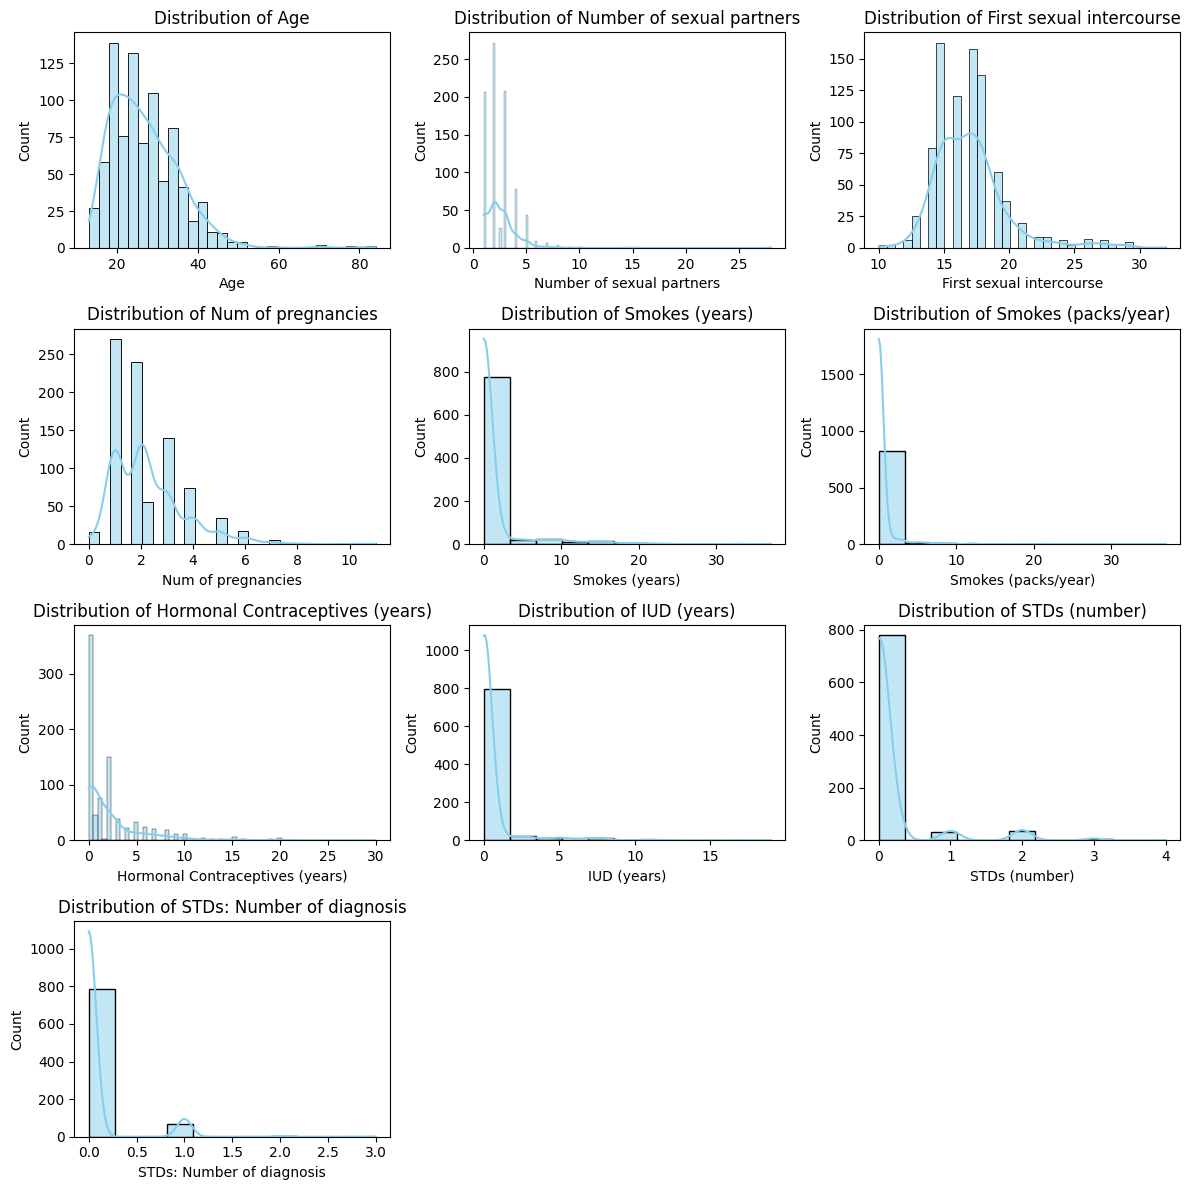

In [ ]:
num_cols = 3  
num_rows = (len(continuous_X) + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, num_rows * 3))
axes = axes.flatten()

for i, col in enumerate(continuous_X):
    sns.histplot(X[col], kde=True, ax=axes[i], color='skyblue')
    axes[i].set_title(f'Distribution of {col}')

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


/var/folders/9v/qnyr17lj5xd0hkt64mdqxgtm0000gn/T/ipykernel_22907/1211666737.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=X, ax=axes[i], palette='Set2')
/var/folders/9v/qnyr17lj5xd0hkt64mdqxgtm0000gn/T/ipykernel_22907/1211666737.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=X, ax=axes[i], palette='Set2')
/var/folders/9v/qnyr17lj5xd0hkt64mdqxgtm0000gn/T/ipykernel_22907/1211666737.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=X, ax=axes[i], palette='Set2')
/var/folders/9v/qnyr17lj5xd0

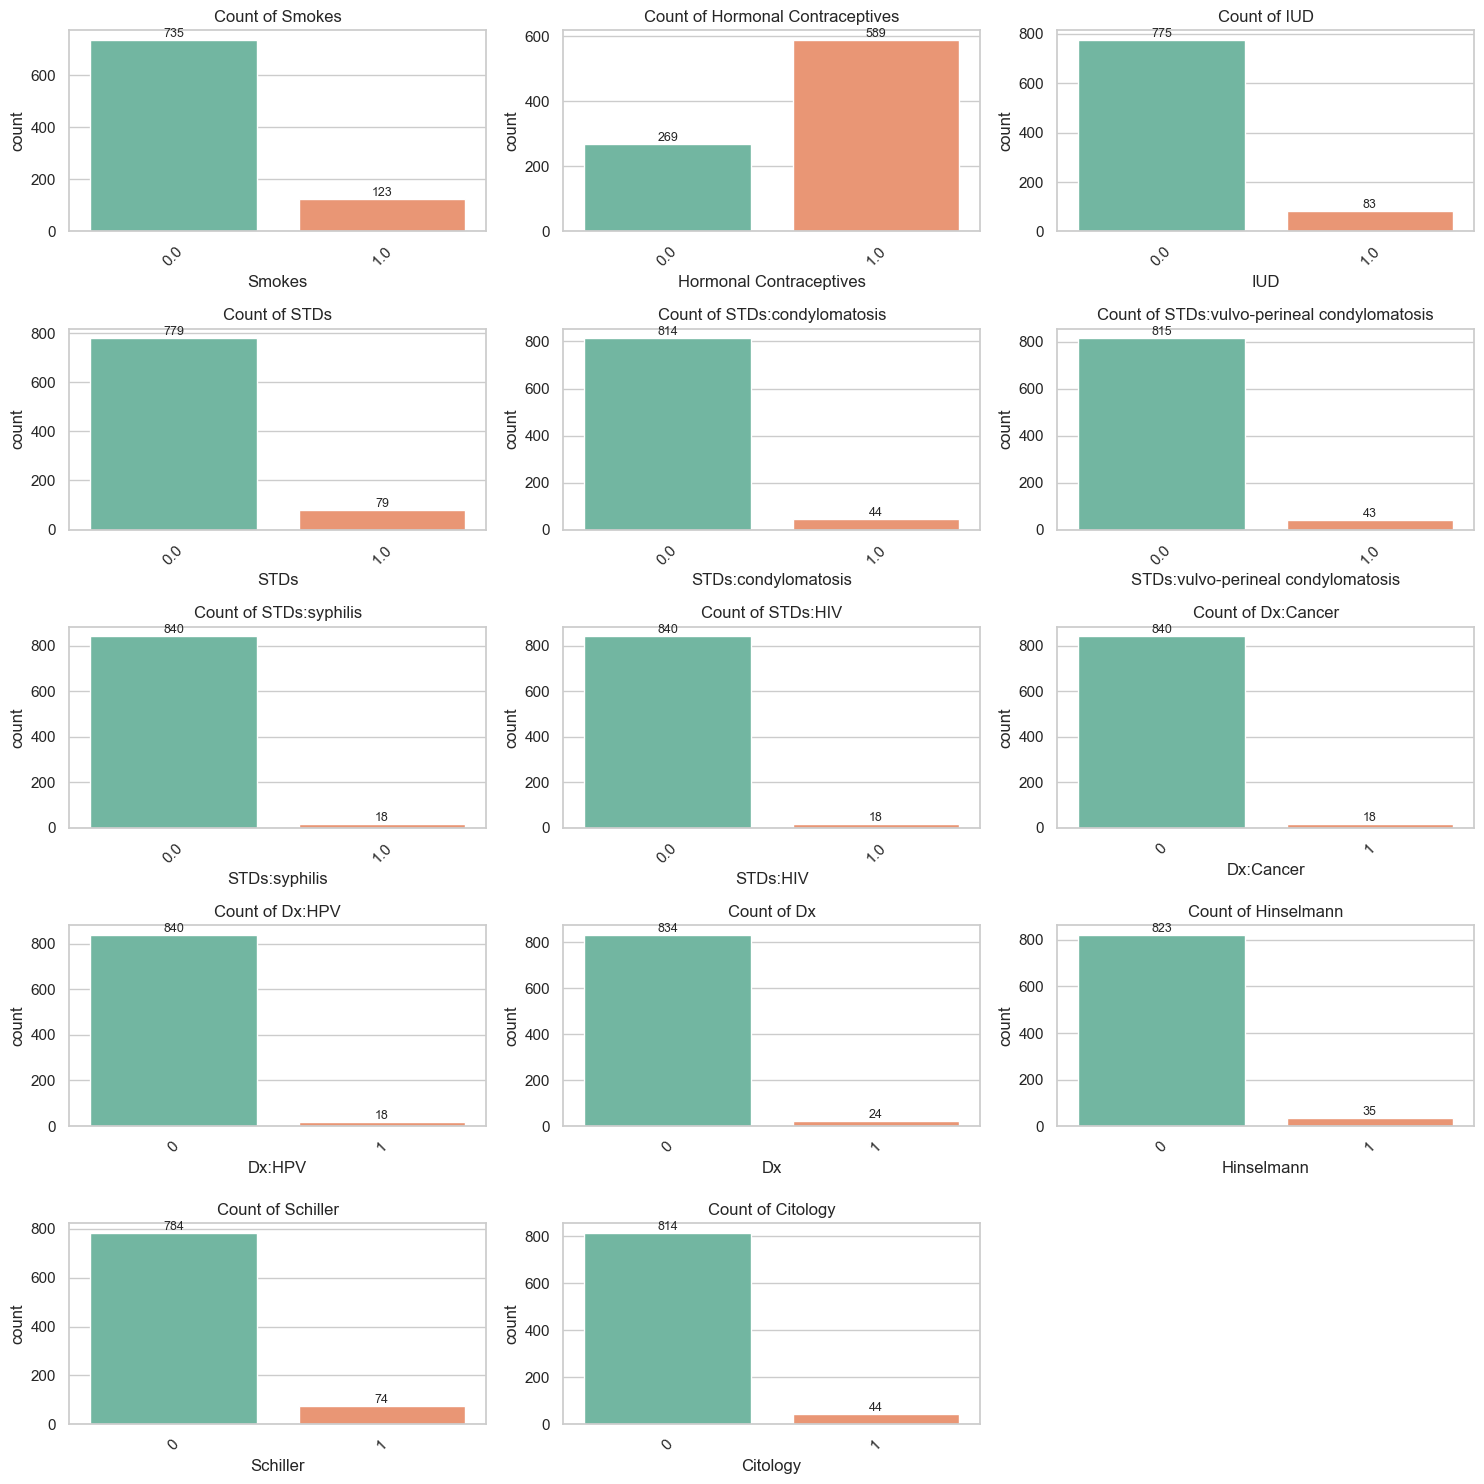

In [ ]:
num_cols = 3
num_rows = (len(categorical_X) + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 3))
axes = axes.flatten()

for i, col in enumerate(categorical_X):
    sns.countplot(x=col, data=X, ax=axes[i], palette='Set2')
    axes[i].set_title(f'Count of {col}')
    axes[i].tick_params(axis='x', rotation=45)
    
    for p in axes[i].patches:
        height = p.get_height()
        axes[i].annotate(f'{int(height)}',
                         (p.get_x() + p.get_width() / 2., height),
                         ha='center', va='bottom', fontsize=9)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


/var/folders/9v/qnyr17lj5xd0hkt64mdqxgtm0000gn/T/ipykernel_22907/1159947786.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=y['Biopsy'], palette='Set2')


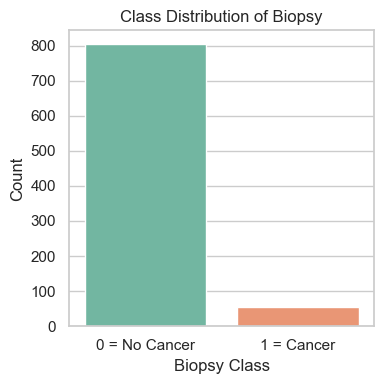

In [186]:
plt.figure(figsize=(4, 4))  # width=8, height=6 (in inches)

sns.set(style="whitegrid")

ax = sns.countplot(x=y['Biopsy'], palette='Set2')

plt.title('Class Distribution of Biopsy')
plt.xlabel('Biopsy Class')
plt.ylabel('Count')

ax.set_xticks([0, 1])

ax.set_xticklabels(['0 = No Cancer', '1 = Cancer'])

plt.tight_layout()
plt.show()


### Traning/testing data spliting & scaling 

In [187]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)


/Users/nuonachen/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


### Decision Tree ~~~~~

In [188]:
param_grid = {
    'max_depth': [2, 4, 6, 8, 10],
    'min_samples_split': [2, 5, 10, 14, 17, 20],
    'min_samples_leaf': [1, 5, 10],
    'class_weight': [None, 'balanced'],
    'criterion': ['gini', 'entropy']
}


dt = DecisionTreeClassifier(random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    scoring='recall',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

In [189]:
grid_search.fit(X_train_res, y_train_res)

best_dt = grid_search.best_estimator_

y_prob = best_dt.predict_proba(X_test)[:, 1]


Fitting 5 folds for each of 360 candidates, totalling 1800 fits


In [154]:
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_prob)
f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold = thresholds_pr[f1_scores.argmax()]
print("Best threshold:", best_threshold)



Best threshold: 0.9737827715355806


In [191]:
y_pred = (y_prob >= best_threshold).astype(int)


In [192]:
print("\nBest Parameters:")
print(grid_search.best_params_)

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print(f"\nROC AUC: {roc_auc_score(y_test, y_prob):.4f}")



Best Parameters:
{'class_weight': None, 'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 2}

Confusion Matrix:
[[156   5]
 [  3   8]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       161
           1       0.62      0.73      0.67        11

    accuracy                           0.95       172
   macro avg       0.80      0.85      0.82       172
weighted avg       0.96      0.95      0.96       172


ROC AUC: 0.8193


### Random Forest ~~~~

In [193]:
param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2'],
    'class_weight': ['balanced', None]
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    scoring='recall',  
    cv=5,
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train_res, y_train_res)
best_rf = grid_search.best_estimator_

y_prob = best_rf.predict_proba(X_test)[:, 1]


Fitting 5 folds for each of 96 candidates, totalling 480 fits


/Users/nuonachen/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/nuonachen/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/nuonachen/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/nuonachen/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 

In [194]:
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_prob)
f1_scores = 2 * (precision * recall) / (precision + recall)
f1_scores = np.nan_to_num(f1_scores)  # convert NaN to 0

best_threshold = thresholds_pr[f1_scores.argmax()]
print("Best threshold:", best_threshold)



Best threshold: 0.44


/var/folders/9v/qnyr17lj5xd0hkt64mdqxgtm0000gn/T/ipykernel_22907/1488317824.py:2: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


/var/folders/9v/qnyr17lj5xd0hkt64mdqxgtm0000gn/T/ipykernel_22907/1008402665.py:4: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1])


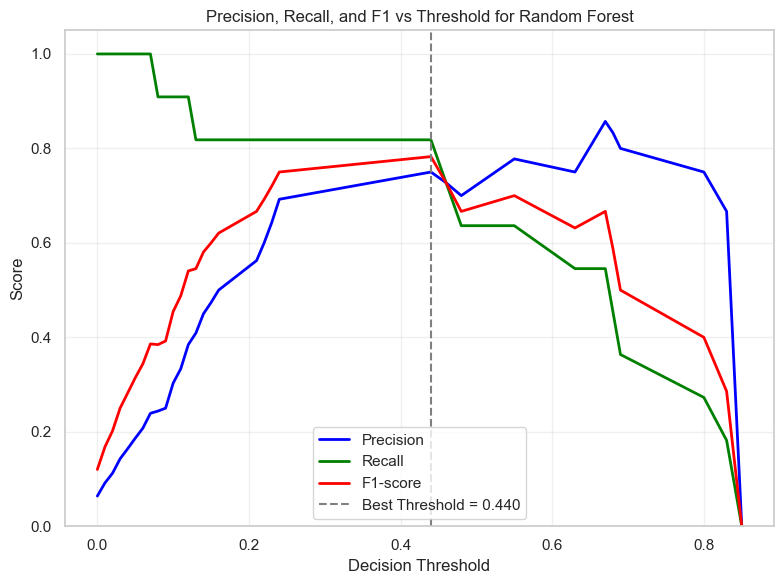

In [195]:
plt.figure(figsize=(8,6))
plt.plot(thresholds_pr, precision[:-1], label='Precision', color='blue', linewidth=2)
plt.plot(thresholds_pr, recall[:-1], label='Recall', color='green', linewidth=2)
f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1])
f1_scores = np.nan_to_num(f1_scores)  # convert NaN to 0
plt.plot(thresholds_pr, f1_scores, label='F1-score', color='red', linewidth=2)

best_idx = np.argmax(f1_scores)
plt.axvline(x=thresholds_pr[best_idx], color='gray', linestyle='--', label=f'Best Threshold = {thresholds_pr[best_idx]:.3f}')

plt.title('Precision, Recall, and F1 vs Threshold for Random Forest')
plt.xlabel('Decision Threshold')
plt.ylabel('Score')
plt.ylim(0, 1.05)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [196]:
y_pred = (y_prob >= best_threshold).astype(int)

In [197]:
print("\nBest Parameters:")
print(grid_search.best_params_)

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print(f"\nROC AUC: {roc_auc_score(y_test, y_prob):.4f}")



Best Parameters:
{'class_weight': 'balanced', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Confusion Matrix:
[[158   3]
 [  2   9]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       161
           1       0.75      0.82      0.78        11

    accuracy                           0.97       172
   macro avg       0.87      0.90      0.88       172
weighted avg       0.97      0.97      0.97       172


ROC AUC: 0.9653


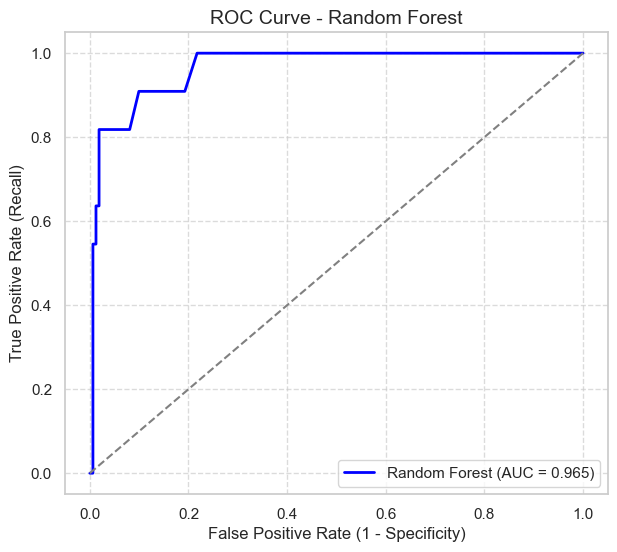

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

# Plot ROC curve
plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, color='blue', lw=2,
         label=f'Random Forest (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # diagonal line

# Formatting
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
plt.ylabel('True Positive Rate (Recall)', fontsize=12)
plt.title('ROC Curve - Random Forest', fontsize=14)
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


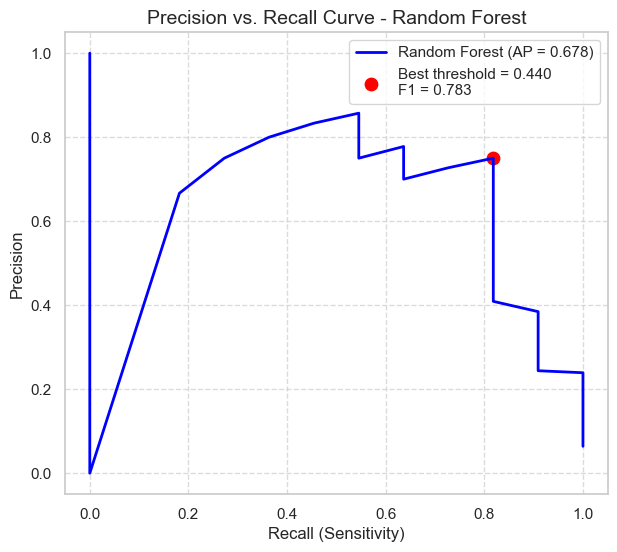

In [ ]:
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_prob)
avg_pr = average_precision_score(y_test, y_prob)

best_idx = f1_scores[:-1].argmax()   
best_threshold = thresholds_pr[best_idx]
best_f1 = f1_scores[best_idx]

plt.figure(figsize=(7,6))
plt.plot(recall, precision, color='blue', lw=2,
         label=f'Random Forest (AP = {avg_pr:.3f})')

plt.scatter(recall[best_idx], precision[best_idx], color='red', s=80,
            label=f'Best threshold = {best_threshold:.3f}\nF1 = {best_f1:.3f}')

plt.xlabel('Recall (Sensitivity)', fontsize=12)
plt.ylabel('Precision', fontsize=12)

plt.title('Precision vs. Recall Curve - Random Forest', fontsize=14)
plt.legend(loc="best")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()



### AdaBoost ~~~~

In [200]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1],
    'algorithm': ['SAMME', 'SAMME.R']
}
grid_search = GridSearchCV(
    estimator=AdaBoostClassifier(random_state=42),
    param_grid=param_grid,
    scoring='recall',  # or 'roc_auc', 'recall', etc.
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_res, y_train_res)
best_ada = grid_search.best_estimator_

y_prob = best_ada.predict_proba(X_test)[:, 1]


Fitting 5 folds for each of 18 candidates, totalling 90 fits


/Users/nuonachen/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nuonachen/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nuonachen/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nuonachen/Library/Python/3.9/lib/python/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is d

In [201]:
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_prob)
f1_scores = 2 * (precision * recall) / (precision + recall)
f1_scores = np.nan_to_num(f1_scores)  

best_threshold = thresholds_pr[f1_scores.argmax()]
print("Best threshold:", best_threshold)



Best threshold: 0.48813728504213366


In [202]:
y_pred = (y_prob >= best_threshold).astype(int)


In [203]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print(f"\nROC AUC: {roc_auc_score(y_test, y_prob):.4f}")


Confusion Matrix:
[[157   4]
 [  3   8]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       161
           1       0.67      0.73      0.70        11

    accuracy                           0.96       172
   macro avg       0.82      0.85      0.84       172
weighted avg       0.96      0.96      0.96       172


ROC AUC: 0.9396
